In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
import pandas as pd
from catboost import CatBoostClassifier
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Monter Google Drive
drive.mount('/content/drive')

# Chemins vers les fichiers
train_path = '/content/drive/My Drive/machinelearning/train.csv'
test_path = '/content/drive/My Drive/machinelearning/test.csv'

# Chargement des données par morceaux et échantillonnage
chunksize = 10 ** 7
num_of_chunk = 0
train = pd.DataFrame()

for chunk in pd.read_csv(train_path, chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=0.01)], axis=0, ignore_index=True)
    print(f'Chunk {num_of_chunk} traité.')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Chunk 1 traité.
Chunk 2 traité.
Chunk 3 traité.
Chunk 4 traité.
Chunk 5 traité.


0    14102202
1    14102209
2    14102112
3    14102209
4    14102209
Name: hour, dtype: int64
[14102202 14102209 14102112 14102115 14102102 14102121 14102103 14102100
 14102219 14102106 14102104 14102203 14102205 14102107 14102201 14102210
 14102303 14102215 14102213 14102118 14102206 14102111 14102207 14102105
 14102211 14102212 14102221 14102109 14102301 14102222 14102204 14102216
 14102123 14102108 14102208 14102110 14102302 14102120 14102116 14102218
 14102117 14102113 14102200 14102223 14102214 14102220 14102304 14102217
 14102114 14102119 14102300 14102122 14102101 14102518 14102308 14102321
 14102511 14102313 14102406 14102307 14102512 14102408 14102315 14102312
 14102515 14102319 14102521 14102510 14102306 14102520 14102517 14102514
 14102407 14102323 14102402 14102410 14102414 14102519 14102403 14102412
 14102516 14102314 14102309 14102416 14102318 14102305 14102413 14102320
 14102501 14102417 14102400 14102504 14102311 14102505 14102509 14102310
 14102405 14102418 14102503 1

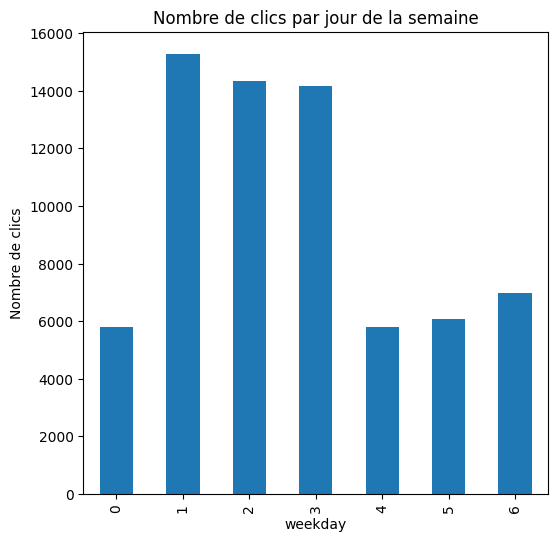

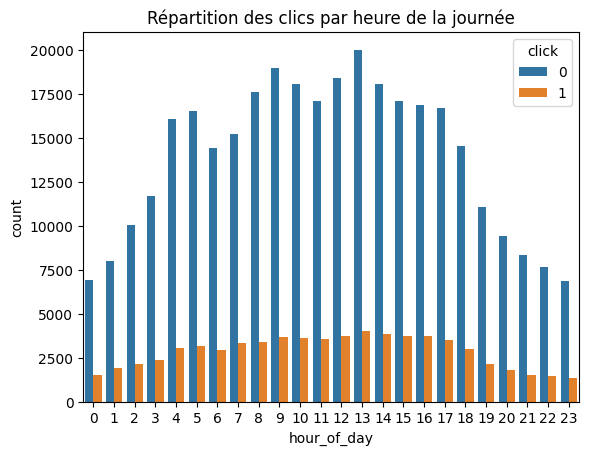

0:	learn: 0.6334205	test: 0.6333462	best: 0.6333462 (0)	total: 250ms	remaining: 4m 9s
200:	learn: 0.3829412	test: 0.4044933	best: 0.4044346 (190)	total: 4.46s	remaining: 17.7s
400:	learn: 0.3620981	test: 0.4049816	best: 0.4043169 (245)	total: 11.2s	remaining: 16.7s
600:	learn: 0.3440730	test: 0.4067373	best: 0.4043169 (245)	total: 15.4s	remaining: 10.2s
800:	learn: 0.3283244	test: 0.4089694	best: 0.4043169 (245)	total: 20.1s	remaining: 5.01s
999:	learn: 0.3137051	test: 0.4116873	best: 0.4043169 (245)	total: 26.5s	remaining: 0us
bestTest = 0.4043169237
bestIteration = 245
Shrink model to first 246 iterations.
          Feature Id  Importances
0            site_id     8.030932
1        site_domain     7.446844
2       device_model     6.571925
3                C21     6.490992
4        hour_of_day     5.769336
5                C18     5.765485
6                C20     5.631288
7          device_ip     5.334374
8                C14     5.013756
9                C19     4.818259
10        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Chargement du fichier de test
test = pd.read_csv(test_path)

# Vérifiez les valeurs uniques dans la colonne 'hour'
print(train['hour'].head())

# Suppression des valeurs incorrectes
train = train[train['hour'].apply(lambda x: len(str(x)) == 8)]
test = test[test['hour'].apply(lambda x: len(str(x)) == 8)]

# Vérifiez à nouveau après le nettoyage
print(train['hour'].unique())

# Transformation de la colonne 'hour' en datetime
train['hour'] = pd.to_datetime(train['hour'], format='%y%m%d%H')
test['hour'] = pd.to_datetime(test['hour'], format='%y%m%d%H')

# Extraire des features temporelles
train['day'] = train['hour'].dt.day
train['hour_of_day'] = train['hour'].dt.hour
train['weekday'] = train['hour'].dt.dayofweek

test['day'] = test['hour'].dt.day
test['hour_of_day'] = test['hour'].dt.hour
test['weekday'] = test['hour'].dt.dayofweek

print(train.head())
print(test.head())

# Analyse exploratoire des données
if not train.empty:
    train.groupby('weekday')['click'].sum().plot.bar(figsize=(6,6))
    plt.ylabel('Nombre de clics')
    plt.title('Nombre de clics par jour de la semaine')
    plt.show()

    sns.countplot(x='hour_of_day', hue='click', data=train)
    plt.title('Répartition des clics par heure de la journée')
    plt.show()
else:
    print("Les données d'entraînement sont vides après nettoyage.")

# Transformation des variables catégorielles
obj_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in obj_cols:
    train[col] = train[col].apply(lambda x: hash(x))
    test[col] = test[col].apply(lambda x: hash(x))

# Sélection des features et de la target
X = train.drop(['id', 'click', 'hour'], axis=1)
y = train['click']
X_test = test.drop(['id', 'hour'], axis=1)

# Séparation des données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Modèle CatBoost avec GPU
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    task_type='GPU',
    loss_function='Logloss',
    depth=10,
    verbose=200
)

# Entraînement du modèle
cat_features = X.select_dtypes(include=['object']).columns.tolist()
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, verbose=200)

# Importance des features
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Prédictions sur l'ensemble de test
predictions = model.predict_proba(X_test)[:, 1]

# Création du fichier de soumission
submission = pd.DataFrame({'id': test['id'], 'click': predictions})
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

In [3]:
# Créer le fichier de soumission
submission = pd.DataFrame({'id': test['id'], 'click': predictions})
submission['id'] = submission['id'].apply(lambda x: f'{x:.0f}')
print(submission.head(10))
submission.to_csv('submission.csv', index=False)

# Télécharger le fichier de soumission
files.download('submission.csv')

                     id     click
0  10000174058809264128  0.062965
1  10000182526920855552  0.191601
2  10000554139829213184  0.250816
3  10001094637809799168  0.034652
4  10001377041558671360  0.278267
5  10001521204153354240  0.177019
6  10001911056707022848  0.155341
7  10001982898844213248  0.026442
8  10002000217531287552  0.088509
9  10002107385290586112  0.145857


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>